# =============================
# Script 3 : test_on_TCGA.py
# =============================

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils import DATA_MODALITIES, RAW_BOTH_DATA_FOLDER, BOTH_SCREENING_DATA_FOLDER, CCLE_RAW_DATA_FOLDER, CCLE_SCREENING_DATA_FOLDER, TCGA_DATA_FOLDER, TCGA_SCREENING_DATA

from data_loader_pretraining import RawDataLoader
from evaluation import Evaluation
from mlp import MLP

# À choisir ci-dessous quel type de script utiliser : SimpleAutoencoder (MSE LOSS) vs. ZINBAutoencoder (ZINB loss)
from pretrain_autoencoders import SimpleAutoencoder
#from pretrain_autoencoders_ZINB import ZINBAutoencoder

# Utiliser le GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu
cpu


Reading Raw Data Files...:   0%|                                                                 | 0/5 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  40%|██████████████████████▊                                  | 2/5 [00:27<00:41, 13.88s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  60%|██████████████████████████████████▏                      | 3/5 [00:53<00:37, 18.80s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                         

tcga_data when loaded: dict_keys(['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger'])
cell_exp: (59, 17737)
cell_mut: (59, 15009)
drug_desc: (32, 209)
drug_finger: (32, 4048)
Preparing data...
sensitive train data len: 112
resistance train data len: 18
x_cell_tcga shape: (130, 30879)
x_drug_tcga shape: (130, 4257)
Distribution des classes : Counter({np.float64(0.0): 18, np.float64(1.0): 18})
Confusion matrix:
[[ 7 11]
 [ 8 10]]
Accuracy: 0.472, Precision: 0.389, Recall: 0.467, F1 score: 0.424, AUC: 0.444, ,AUPRC: 0.619


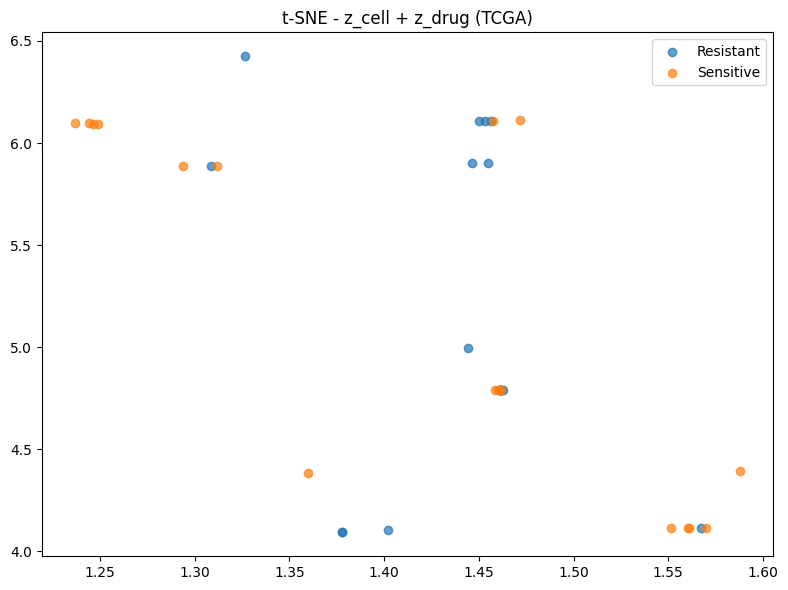

Final Results:
AVG: Accuracy: 0.472, Precision: 0.389, Recall: 0.467, F1 score: 0.424, AUC: 0.444, ,AUPRC: 0.619
 Average AUC: 0.444 	 Average AUPRC: 0.619 	 Std AUPRC: 0.000


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def test_on_TCGA(run_id=0):
    set_seed(42)
    # Initialisation de l'historique des métriques
    history = {'AUC': [], 'AUPRC': [], "Accuracy": [], "Precision": [], "Recall": [], "F1 score": []}
    
    # Load TCGA data
    tcga_data, tcga_screen = RawDataLoader.load_data(
        data_modalities=DATA_MODALITIES,
        raw_file_directory=TCGA_DATA_FOLDER,
        screen_file_directory=TCGA_SCREENING_DATA,
        sep="\t")
    
    print('tcga_data when loaded:', tcga_data.keys())
    for key, df in tcga_data.items():
        print(f"{key}: {df.shape}")

    import pickle
    
    with open("feature_columns.pkl", "rb") as f:
        all_features = pickle.load(f)

    for key in ['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger']:    # to modify depending on the modalities used for pretraining
        tcga_data[key] = tcga_data[key].reindex(columns=all_features[key], fill_value=0.0)
    
    x_cell_tcga, x_drug_tcga, y_tcga, cell_sizes, drug_sizes = RawDataLoader.prepare_input_data(tcga_data, tcga_screen)

    print('x_cell_tcga shape:', x_cell_tcga.shape)
    print('x_drug_tcga shape:', x_drug_tcga.shape)

    # Application d'un sous-échantillonnage pour équilibrer la classe majoritaire    
    rus = RandomUnderSampler(sampling_strategy="majority", random_state=42)
    dataset = pd.concat([x_cell_tcga, x_drug_tcga], axis=1)
    dataset.index = x_cell_tcga.index
    dataset, y_tcga = rus.fit_resample(dataset, y_tcga)
    x_cell_tcga = dataset.iloc[:, :sum(cell_sizes)]
    x_drug_tcga = dataset.iloc[:, sum(cell_sizes):]

    from collections import Counter
    print("Distribution des classes :", Counter(y_tcga))
    
    # Convert into PyTorch tensors
    x_cell_tensor = torch.Tensor(x_cell_tcga.values).to(device)
    x_drug_tensor = torch.Tensor(x_drug_tcga.values).to(device)
    y_tensor = torch.Tensor(y_tcga).unsqueeze(1).to(device)
  
    x_cell_tensor = torch.nn.functional.normalize(x_cell_tensor, dim=0)
    x_drug_tensor = torch.nn.functional.normalize(x_drug_tensor, dim=0)
    
    test_dataset = TensorDataset(x_cell_tensor, x_drug_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=torch.Generator().manual_seed(42))

    # latent dim
    cell_latent_dim = 700
    drug_latent_dim = 50

    # Load trained models from script_2
    encoder_cell = torch.load(f"encoder_cell_trained_run_{run_id}.pt", weights_only=False).to(device)
    
    encoder_drug = torch.load(f"encoder_drug_trained_run_{run_id}.pt", weights_only=False).to(device)
    
    mlp = MLP(cell_latent_dim + drug_latent_dim, 1)
    mlp.load_state_dict(torch.load(f"mlp_trained_run_{run_id}.pth"))
    mlp = mlp.to(device)
    
    # Prediction
    model = nn.Module()
    model.encoder_cell = encoder_cell
    model.encoder_drug = encoder_drug
    model.mlp = mlp
    
    model.eval()
    with torch.no_grad():
        z_cell = encoder_cell(x_cell_tensor)
        z_drug = encoder_drug(x_drug_tensor)
        combined = torch.cat([z_cell, z_drug], dim=1)
        y_pred = mlp(combined)
    

    results = Evaluation.evaluate(y_tensor.cpu(), y_pred.cpu())

    history = Evaluation.add_results(history, results)
    
    # t-SNE on TCGA
    z_combined = combined.cpu().numpy()
    y_np = y_tensor.cpu().numpy().ravel()
    
    tsne = TSNE(n_components=2, random_state=42)
    z_embedded = tsne.fit_transform(z_combined)
    
    plt.figure(figsize=(8,6))
    for label, color in zip([0,1], ['blue', 'red']):
        plt.scatter(z_embedded[y_np == label, 0], z_embedded[y_np == label, 1],
                    label='Resistant' if label == 0 else 'Sensitive', alpha=0.7)
    plt.title("t-SNE - z_cell + z_drug (TCGA)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    ##(optional) Save embeddings for further analysis
    #np.save(f"z_cell_TCGA_run_{run_id}.npy", z_cell.cpu().numpy())
    #np.save(f"z_drug_TCGA_run_{run_id}.npy", z_drug.cpu().numpy())
    #np.save(f"y_TCGA_run_{run_id}.npy", y_np)
    
    return history

if __name__ == "__main__":
    history = test_on_TCGA(run_id=0)
    Evaluation.show_final_results(history)